# Tarea Redes Neuronales Profundas
---
Nombre: Javier Esteban Peña Reyes\
Rut: 18.706.047-8

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_datasets as tfds
# df = pcam
#df, pcam_info = tfds.load("patch_camelyon", with_info=True)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'patch_camelyon',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
    data_dir=r'/content/drive/MyDrive/dataset_patch_camelyon/')




Shuffling and writing examples to /content/drive/MyDrive/dataset_patch_camelyon/patch_camelyon/2.0.0.incompleteHQ5RRJ/patch_camelyon-test.tfrecord


Shuffling and writing examples to /content/drive/MyDrive/dataset_patch_camelyon/patch_camelyon/2.0.0.incompleteHQ5RRJ/patch_camelyon-train.tfrecord


Shuffling and writing examples to /content/drive/MyDrive/dataset_patch_camelyon/patch_camelyon/2.0.0.incompleteHQ5RRJ/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /content/drive/MyDrive/dataset_patch_camelyon/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [3]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)

  return image, label

raw_train = raw_train.map(augment_data)

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = raw_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(metadata.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = raw_validation.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
def convert_sample(sample, label):
    image, label = sample, label
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

train_pipeline = raw_train.map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = raw_validation.map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)
test_pipeline = raw_test.map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)

El Dataset de imágenes escogidos para esta tarea fue Patch Camelyon, el cual posee imagenes de escáneres de ganclios linfáticos.Estas imagenes pueden corresponder a 2 clases:
- Existen pixeles correspondientes a tumores linfáticos en la imagen

- No existen pixeles correspondientes a tumores linfáticos en la imagen

Para la realización de la tarea, se crearon 2 arquitecturas convolucionales distintas: Una propia y AlexNet.


### Arquitectura propia

La arquitectura propuesta consiste en lo siguiente:

 - 2 capas convolucionales, con kernel de 3x3, activación ReLu y salida de 16 dimensiones.

- Luego, se aplica una capa de maxPooling de 2x2

- Se aplican 2 capas convolucionales de 3x3, con profundidad de 32

- Otra capa de max pooling de 2x2

- Otras 2 capas convolucionales con kernel 3x3 y ReLu como activación.

- Una capa de Maxpool final de 2x2

- Las ultimas 2 capas convolucionales con kernel 3x3 y ReLu como activación.

- Una capa de Maxpool final de 2x2

Para finalmente pasar la salida 2 capas Fully-conected con dropout del 0.2 para ambas, una de 256 nodos y otra de 128



In [9]:
#First setup the input to the network which has the dimensions of the patches contained within PatchCAMELYON
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
predictions = Dense(2, activation='softmax')(x)

# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
model = Model(inputs=input_img, outputs=predictions)
sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 44, 44, 32)        4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 21, 21, 32)        0   

En base a la arquitectura propuesta, se entrenan los datos para probar el rendimiento de la red neuronal con un set de prueba distinto al original.

In [13]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=10, steps_per_epoch=4096, validation_steps=256)

print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Epoch 1/10
4096/4096 - 303s - loss: 0.5619 - accuracy: 0.7103 - val_loss: 0.4462 - val_accuracy: 0.7967
Epoch 2/10
4096/4096 - 286s - loss: 0.4466 - accuracy: 0.7985 - val_loss: 0.4032 - val_accuracy: 0.8147
Epoch 3/10
4096/4096 - 291s - loss: 0.3908 - accuracy: 0.8270 - val_loss: 0.3479 - val_accuracy: 0.8512
Epoch 4/10
4096/4096 - 293s - loss: 0.3592 - accuracy: 0.8451 - val_loss: 0.3157 - val_accuracy: 0.8671
Epoch 5/10
4096/4096 - 278s - loss: 0.3417 - accuracy: 0.8536 - val_loss: 0.2879 - val_accuracy: 0.8793
Epoch 6/10
4096/4096 - 301s - loss: 0.3245 - accuracy: 0.8626 - val_loss: 0.3018 - val_accuracy: 0.8796
Epoch 7/10
4096/4096 - 294s - loss: 0.3123 - accuracy: 0.8692 - val_loss: 0.2811 - val_accuracy: 0.8849
Epoch 8/10
4096/4096 - 283s - loss: 0.2988 - accuracy: 0.8756 - val_loss: 0.2783 - val_accuracy: 0.8884
Epoch 9/10
4096/4096 - 344s - loss: 0.2914 - accuracy: 0.8795 - val_loss: 0.2670 - val_accuracy: 0.8885
Epoch 10/10
4096/4096 - 288s - loss: 0.2819 - accuracy: 0.8840 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


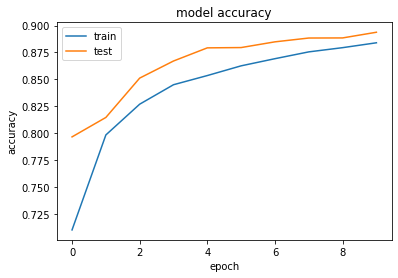

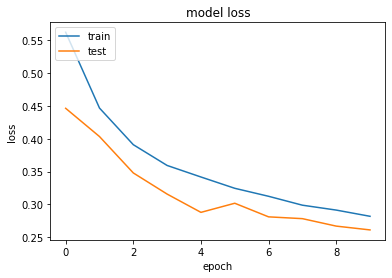

In [14]:
import matplotlib.pyplot as plt

print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

En base a los graficos y el resultado obtenido por la evaluacion del modelo con los datos de prueba, se puede apreciar que el modelo posee un overfitting a los datos iniciales, ya que la arquitectura se ajusta demaciado a los datos iniciales, perjudicando a los datos de validacion y los datos de prueba.

# Arquitectura AlexNet
Esta arquitectura es presentada por Alex Krizevsky para completar el desafio de ImageNet de septiembre 30, 2012. Esta red esta compuesta principalmente de 8 capas importantes:


*   Las primeras 5 capas son capas convolucionales. Algunas de estas capas estan acompañadas de capas de max-pooling.
*   Las ultimas 3 capas son capas Fully-conected

Toda la red neuronal utiliza la funcion de activacion ReLu, exeptuando la capa final, ya que esta presenta mejores resultados que las funciones tangentes y sigmoide.



In [15]:
x = None
from tensorflow.keras.layers import LayerNormalization,ZeroPadding2D
#First setup the input to the network which has the dimensions of the patches contained within PatchCAMELYON
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = ZeroPadding2D((1,1))(input_img)
x = Conv2D(48, (11, 11), strides=(2,2), padding='valid', activation='relu')(x)
x = ZeroPadding2D((1,1))(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = ZeroPadding2D((1,1))(x)
x = Conv2D(192, (2, 2), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = ZeroPadding2D((1,1))(x)
x = Conv2D(192, (2, 2), padding='valid', activation='relu')(x)
x = ZeroPadding2D((1,1))(x)
x = Conv2D(192, (2, 2), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)


# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
predictions = Dense(2, activation='softmax')(x)

# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
model = Model(inputs=input_img, outputs=predictions)
sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 98, 98, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 44, 44, 48)        17472     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 46, 46, 48)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 44, 44, 128)       55424     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 24, 24, 128)       0   

In [16]:
hist = model.fit_generator(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=10, steps_per_epoch=4096, validation_steps=256)

print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


4096/4096 - 291s - loss: 0.6378 - accuracy: 0.6191 - val_loss: 0.5305 - val_accuracy: 0.7320
Epoch 2/10
4096/4096 - 330s - loss: 0.5054 - accuracy: 0.7605 - val_loss: 0.5014 - val_accuracy: 0.7657
Epoch 3/10
4096/4096 - 293s - loss: 0.4576 - accuracy: 0.7895 - val_loss: 0.4126 - val_accuracy: 0.8143
Epoch 4/10
4096/4096 - 306s - loss: 0.4187 - accuracy: 0.8125 - val_loss: 0.3992 - val_accuracy: 0.8226
Epoch 5/10
4096/4096 - 296s - loss: 0.3886 - accuracy: 0.8278 - val_loss: 0.3676 - val_accuracy: 0.8424
Epoch 6/10
4096/4096 - 266s - loss: 0.3638 - accuracy: 0.8409 - val_loss: 0.3325 - val_accuracy: 0.8588
Epoch 7/10
4096/4096 - 308s - loss: 0.3396 - accuracy: 0.8537 - val_loss: 0.3181 - val_accuracy: 0.8685
Epoch 8/10
4096/4096 - 286s - loss: 0.3203 - accuracy: 0.8635 - val_loss: 0.2972 - val_accuracy: 0.8753
Epoch 9/10
4096/4096 - 301s - loss: 0.3029 - accuracy: 0.8715 - val_loss: 0.3434 - val_accuracy: 0.8531
Epoch 10/10
4096/4096 - 279s - loss: 0.2859 - accuracy: 0.8796 - val_loss: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


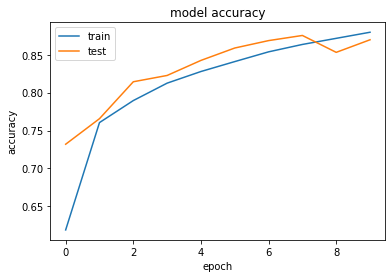

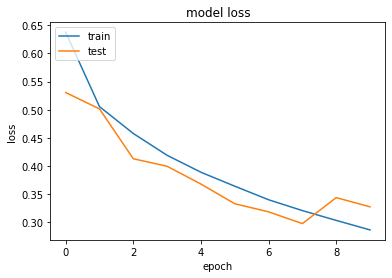

In [17]:
import matplotlib.pyplot as plt

print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Esta arquitectura comparada con la arquitectura propuesta anteriormente, presenta similares resultados durante el entrenamiento, pero presenta un menor rendimiento al momento de validar la red neuronal con datos separados.

# Arquitectura Pre-Entrenada
La siguiente arquitectura para comparar los datos sera InceptionV3, que posee un modelo pre-entrenado con pesos existentes. Esta red neuronal utilizara los pesos iniciales proveidos por ImageNet para luego adjuntarle una capa de AveragePooling y 2 capas densas, con el objetivo de reducir la salida predefinida de 1000 clases a las 2 clases del problema.

In [18]:
from keras.applications.inception_v3 import InceptionV3                                                     
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np                      

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
___________________________

In [19]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=10, steps_per_epoch=4096, validation_steps=256)

print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Epoch 1/10
4096/4096 - 437s - loss: 0.2696 - accuracy: 0.8884 - val_loss: 0.2260 - val_accuracy: 0.9110
Epoch 2/10
4096/4096 - 410s - loss: 0.1844 - accuracy: 0.9286 - val_loss: 0.3298 - val_accuracy: 0.8622
Epoch 3/10
4096/4096 - 414s - loss: 0.1580 - accuracy: 0.9398 - val_loss: 0.2299 - val_accuracy: 0.9087
Epoch 4/10
4096/4096 - 430s - loss: 0.1349 - accuracy: 0.9487 - val_loss: 0.1248 - val_accuracy: 0.9545
Epoch 5/10
4096/4096 - 411s - loss: 0.1180 - accuracy: 0.9552 - val_loss: 0.1505 - val_accuracy: 0.9438
Epoch 6/10
4096/4096 - 412s - loss: 0.1074 - accuracy: 0.9597 - val_loss: 0.3804 - val_accuracy: 0.8837
Epoch 7/10
4096/4096 - 422s - loss: 0.1001 - accuracy: 0.9624 - val_loss: 0.1335 - val_accuracy: 0.9518
Epoch 8/10
4096/4096 - 421s - loss: 0.0902 - accuracy: 0.9662 - val_loss: 0.1315 - val_accuracy: 0.9545
Epoch 9/10
4096/4096 - 411s - loss: 0.0836 - accuracy: 0.9680 - val_loss: 0.1690 - val_accuracy: 0.9406
Epoch 10/10
4096/4096 - 423s - loss: 0.0768 - accuracy: 0.9709 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


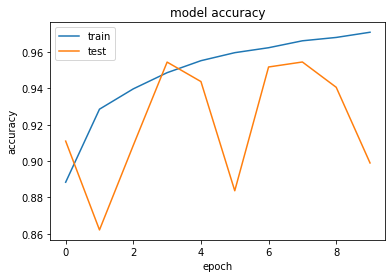

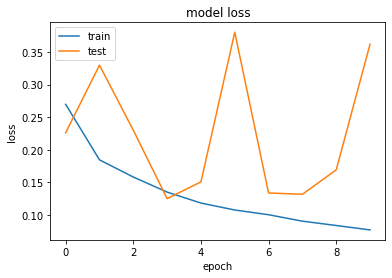

In [20]:
import matplotlib.pyplot as plt

print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

En base a los resultados presentados por la arquitectura prenetrenada, se puede apreciar que el rendimiento durante el entrenaminento es parejo, ya que se estan utilizando los pesos ya calculados y entregados por la libreria de keras.
Con respecto a los resultados de la validacion, estos son similares durante gran parte de las ejecuciones.